# Kaggle Causal Inference

## Importing libraries and reading data

In [1]:
%pip install dowhy -- quiet
%pip install networkx -- quiet

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement quiet (from versions: none)
ERROR: No matching distribution found for quiet


Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement quiet (from versions: none)
ERROR: No matching distribution found for quiet


In [18]:
import numpy as np
import pandas as pd
from dowhy import CausalModel
import networkx as nx

In [3]:
train_set = pd.read_csv('train.csv')
test_set = pd.read_csv('test.csv')

In [4]:
train_set['Pclass'] = train_set['Pclass'].astype(str)
test_set['Pclass'] = test_set['Pclass'].astype(str)

In [26]:
df = train_set.copy()
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Feature Engineering

In [55]:
df['had_cabin'] = ~df.Cabin.isna()
df['is_female'] = (df.Sex == 'female')*1
df['Fare'] = df['Fare'].fillna(0)
df['Age'] = df['Age'].fillna(df['Age'].median())

In [56]:
for pclass in df['Pclass'].unique():
    df[f'is_{pclass}_pclass'] = (df['Pclass'] == pclass )*1

In [57]:
variables = [
    'Age',
    'Fare',
    'SibSp',
    'Parch',
    'had_cabin',
    'is_female',
    'is_1_pclass',
    'is_2_pclass',
    'is_3_pclass',
    'Survived',
]

## Causal Graph

In [58]:
causal_graph = nx.DiGraph(
    [
        ('Age', 'Survived'),
        ('Fare', 'Survived'),
        ('SibSp', 'Survived'),
        ('Parch', 'Survived'),
        ('had_cabin', 'Survived'),
        ('is_female', 'Survived'),
        ('is_1_pclass', 'Survived'),
        ('is_2_pclass', 'Survived'),
        ('is_3_pclass', 'Survived'),
        ('Age', 'SibSp'),
        ('Age', 'Parch'),
        ('Fare', 'is_1_pclass'),
        ('Fare', 'is_2_pclass'),
        ('Fare', 'is_3_pclass'),
        ('SibSp', 'had_cabin'),
        ('Parch', 'had_cabin'),
    ]
)

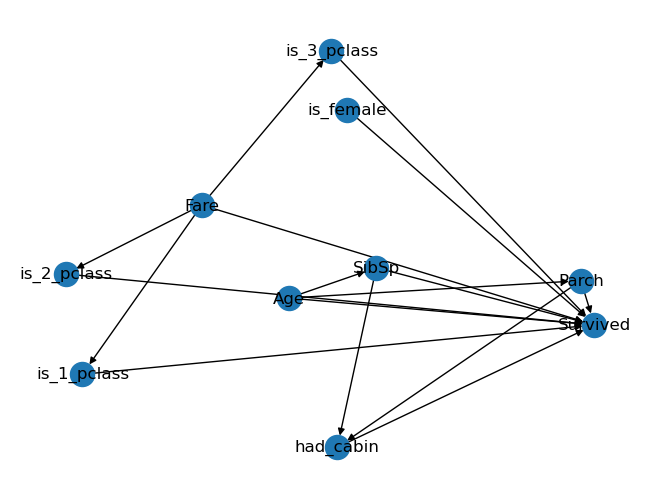

In [59]:
nx.draw(
    causal_graph,
    with_labels=True
)

## Causal Model

In [60]:
treatment_col = 'is_female'
outcome_col = 'Survived'

model = CausalModel(
    data=df[variables],
    treatment = treatment_col,
    outcome=outcome_col,
    graph="\n".join(nx.generate_gml(causal_graph))
)

In [61]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                   
────────────(E[Survived])
d[is_female]             
Estimand assumption 1, Unconfoundedness: If U→{is_female} and U→Survived then P(Survived|is_female,,U) = P(Survived|is_female,)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [62]:
estimate = model.estimate_effect(
    identified_estimand,
    method_name='backdoor.linear_regression',
    target_units='ate',
    method_params={"weighting_scheme":"ips_weight"}
)

In [63]:
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                   
────────────(E[Survived])
d[is_female]             
Estimand assumption 1, Unconfoundedness: If U→{is_female} and U→Survived then P(Survived|is_female,,U) = P(Survived|is_female,)

## Realized estimand
b: Survived~is_female+is_female*Age+is_female*is_2_pclass+is_female*Parch+is_female*Fare+is_female*is_1_pclass+is_female*SibSp+is_female*had_cabin+is_female*is_3_pclass
Target units: ate

## Estimate
Mean value: 0.5307546626867793



In [64]:
refute_placebo_treatment = model.refute_estimate(
    identified_estimand,
    estimate,
    method_name='placebo_treatment_refuter',
    placebo_type='permute'
)

In [65]:
print(refute_placebo_treatment)

Refute: Use a Placebo Treatment
Estimated effect:0.5307546626867793
New effect:-0.004403677383610963
p value:0.86

